In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
from tqdm.notebook import tqdm
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, confusion_matrix

In [3]:
import os
import random
import gc

In [4]:
# seed=1
# reproducible = True
# # Setting the seed before gin parsing
# os.environ['PYTHONHASHSEED'] = str(seed)
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

# if reproducible:
#     os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
#     torch.use_deterministic_algorithms(True)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# get data

In [5]:
class TorchDataset(Dataset):
    def __init__(self, data_path, labels_path):
        self.data = torch.load(data_path)
        self.labels = torch.load(labels_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        data = self.data[idx]
        labels = self.labels[idx]
        # return torch.tensor(data, dtype=torch.float32), torch.tensor(labels, dtype=torch.float32)
        return data.clone().detach(), labels.clone().detach()

In [6]:
# Example usage for creating datasets
train_dataset = TorchDataset('Mortality/Mtrain.pt', 'Mortality/y_train.pt')
valid_dataset = TorchDataset('Mortality/Mvalid.pt', 'Mortality/y_valid.pt')
test_dataset  = TorchDataset('Mortality/Mtest.pt', 'Mortality/y_test.pt')

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=1, pin_memory=True, prefetch_factor=2)
valid_loader = DataLoader(valid_dataset, batch_size=64, shuffle=False, num_workers=1, pin_memory=True, prefetch_factor=2)
test_loader  = DataLoader(test_dataset,  batch_size=64, shuffle=False, num_workers=1, pin_memory=True, prefetch_factor=2)

## model as in Gandin, Ilaria, et al. "Interpretability of time-series deep learning models: A study in cardiovascular patients admitted to Intensive care unit." Journal of biomedical informatics 121 (2021): 103876.

In [8]:
# Define the Attention Layer
class Attention(nn.Module):
    def __init__(self, shape):
        super(Attention, self).__init__()
        self.attention_dense = nn.Linear(shape, shape)
    
    def forward(self, inputs):
        # Apply linear transformation
        a = self.attention_dense(inputs)
        # Apply softmax to get attention scores
        attention_scores = F.softmax(a, dim=-1)
        # Element-wise multiplication with inputs
        output_attention_mul = inputs * attention_scores
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=128):
        super(CustomModel_attext, self).__init__()
        self.attention = Attention(n_features)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, 1)
    
    def forward(self, x, return_attention=False):
        # Get the attended output and attention scores
        x, attention_scores = self.attention(x)
        # Pass through LSTM
        x, _ = self.lstm(x)
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        # Apply the dense layer with sigmoid activation
        x = torch.sigmoid(self.dense(x))
        
        if return_attention:
            return x, attention_scores
        return x

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the Time-based Attention Layer
class TimeAttention(nn.Module):
    def __init__(self, n_wind):
        super(TimeAttention, self).__init__()
        # Apply attention over the time steps instead of features
        self.attention_dense = nn.Linear(n_wind, n_wind)
    
    def forward(self, inputs):
        # Transpose inputs to (batch_size, features, time_steps) to apply time-based attention
        inputs_transposed = inputs.transpose(1, 2)  # Shape: (batch_size, features, time_steps)
        
        # Apply linear transformation to the time dimension
        a = self.attention_dense(inputs_transposed)
        
        # Apply softmax to get attention scores over time dimension
        attention_scores = F.softmax(a, dim=-1)
        
        # Element-wise multiplication with inputs
        output_attention_mul = inputs_transposed * attention_scores
        
        # Transpose back to original shape (batch_size, time_steps, features)
        output_attention_mul = output_attention_mul.transpose(1, 2)
        
        return output_attention_mul, attention_scores

# Define the Model
class CustomModel_attext_time(nn.Module):
    def __init__(self, n_wind, n_features, dense_nparams1=128):
        super(CustomModel_attext_time, self).__init__()
        self.attention = TimeAttention(n_wind)
        self.lstm = nn.LSTM(n_features, dense_nparams1, num_layers=1, batch_first=True)
        self.dense = nn.Linear(dense_nparams1, 1)
    
    def forward(self, x, return_attention=False):
        # Apply time-based attention
        x, attention_scores = self.attention(x)
        
        # Pass through LSTM
        x, _ = self.lstm(x)
        
        # Extract the last output of the LSTM
        x = x[:, -1, :]
        
        # Apply the dense layer with sigmoid activation
        x = torch.sigmoid(self.dense(x))
        
        if return_attention:
            return x, attention_scores
        return x

In [16]:
epochs = 30
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
def train(train_loader, model, criterion, optimizer):

    output_list = []
    target_list = [] 
    # switch to train mode
    model = model.to(device)
    model.train()

    for count, (data, label) in enumerate(train_loader):

        # data in cuda
        data  = data.cuda().type(torch.float)
        label = label.cuda().type(torch.float)
        # label = label.cuda().type(torch.long)
        # compute output
        output = model(data).squeeze(1)

        loss = criterion(output, label)
        output_np = output.detach().cpu().numpy().tolist()
        target_np = label.detach().cpu().numpy().tolist()
        output_list += output_np
        target_list += target_np
        # compute gradient and do Adam step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    return output_list, target_list


def validate(val_loader, model, criterion):

    output_list = []
    target_list = [] 
    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        for count, (data, label) in enumerate(val_loader):
            data  = data.cuda().type(torch.float)
            label = label.cuda().type(torch.float)

            # compute output
            output = model(data).squeeze(1)

            loss = criterion(output, label)

            output_np = output.detach().cpu().numpy().tolist()
            target_np = label.detach().cpu().numpy().tolist()

            output_list += output_np
            target_list += target_np

    return output_list, target_list

In [18]:
# Assuming you have a variable `seed` already defined
model_save_dir = './model_checkpoints/'  # Directory to save models

# Create the directory if it doesn't exist
os.makedirs(model_save_dir, exist_ok=True)

In [ ]:
for i in tqdm(range(1,2)):
    
    seed = i
    reproducible = True
    # Setting the seed before gin parsing
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups

    if reproducible:
        os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
        torch.use_deterministic_algorithms(True)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    
    epoches = [] 
    roc_train = []
    pr_train = []
    roc_val = []
    pr_val = []
    best_roc = 0
    best_pr = 0

    # Create the model
    # model = CustomModel(288, 231)
    model = CustomModel_attext_time(288,231)
    criterion = nn.BCELoss()  # Binary Cross Entropy Loss for binary classification
    optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-6)
    
    print(f'Starting training for seed {seed}')

    for epoch in range(epochs):
        epoches.append(epoch)

        # Train for one epoch
        output_train_per, target_train_per = train(train_loader, model, criterion, optimizer)
        auc_roc_value_train = roc_auc_score(target_train_per, output_train_per)
        auc_pr_value_train = average_precision_score(target_train_per, output_train_per)

        # Record train metrics
        roc_train.append(auc_roc_value_train)
        pr_train.append(auc_pr_value_train)

        print(f'TRAIN, epoch {epoch}, train_roc {auc_roc_value_train:.5f}, train_pr {auc_pr_value_train:.5f}')

        # Evaluate on validation set
        output_val_per, target_val_per = validate(test_loader, model, criterion)
        auc_roc_value_val = roc_auc_score(target_val_per, output_val_per)
        auc_pr_value_val = average_precision_score(target_val_per, output_val_per)

        # Record validation metrics
        roc_val.append(auc_roc_value_val)
        pr_val.append(auc_pr_value_val)

        print(f'VAL, epoch {epoch}, val_roc {auc_roc_value_val:.5f}, val_pr {auc_pr_value_val:.5f}')

        # Check for best ROC
        if auc_roc_value_val > best_roc:
            best_roc = auc_roc_value_val
            torch.save(model.state_dict(), os.path.join(model_save_dir, f'bm_timeattention_seed_{seed:03d}.pth'))
            # print(f'Saved best model by ROC at epoch {epoch} with ROC {best_roc:.5f}')

        # # Check for best PR
        # if auc_pr_value_val > best_pr:
        #     best_pr = auc_pr_value_val
        #     torch.save(model.state_dict(), os.path.join(model_save_dir, f'bm_pr_seed_{seed:03d}.pth'))
        #     # print(f'Saved best model by PR at epoch {epoch} with PR {best_pr:.5f}')
            
    print(f'Completed training and model saving for seed {seed}')

    # del model
    # collect cache
    gc.collect()
    torch.cuda.empty_cache()

In [35]:
# model = CustomModel(288, 231)
model = CustomModel_attext_time(288,231)

In [36]:
model.load_state_dict(torch.load("model_checkpoints/bm_timeattention_seed_000.pth"))
model.eval()  # Set the model to evaluation mode

CustomModel_attext_time(
  (attention): TimeAttention(
    (attention_dense): Linear(in_features=288, out_features=288, bias=True)
  )
  (lstm): LSTM(231, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=1, bias=True)
)

In [18]:
# # After training is complete
# torch.save(model.state_dict(), "Mortality/mortality_weights.pth")
# print("Model weights saved successfully!")

In [37]:
dtest = torch.load('Mortality/Mtest.pt')
ytest = torch.load('Mortality/y_test.pt')

In [38]:
dtest1394 = dtest.numpy()[1394]

In [39]:
# Run the model and make a prediction with attention scores
dtest1394_tensor = torch.tensor(dtest1394).unsqueeze(0).cuda(0)

## visualize the feature x feature matrix

In [40]:
# Extract the weight matrix from the attention_dense layer
weight_matrix = model.attention.attention_dense.weight.data

# Print the shape and values of the weight matrix
print("Shape of the weight matrix:", weight_matrix.shape)
# print("Weight matrix:\n", weight_matrix)

Shape of the weight matrix: torch.Size([288, 288])


In [41]:
wmnp = weight_matrix.detach().cpu().numpy()

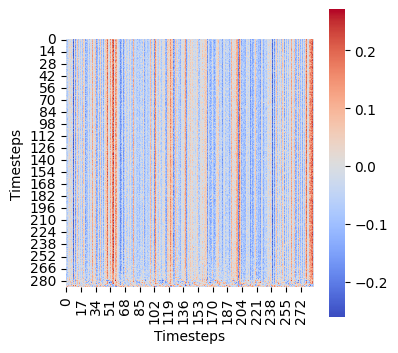

In [42]:
plt.figure(figsize=(4, 4))
sns.heatmap(wmnp, annot=False, cmap='coolwarm', cbar=True, square=True, 
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
           )
# plt.title('Attention Weights')
plt.xlabel("Timesteps")
plt.ylabel("Timesteps")
plt.show()

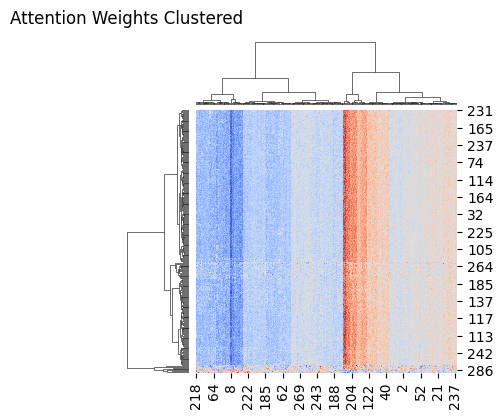

In [56]:
sns.clustermap(wmnp, annot=False, cmap='coolwarm', cbar=False, method='ward',
               # dendrogram_ratio=(0.001, 0.001),
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
               figsize=(4, 4)
           )
plt.title('Attention Weights Clustered')
plt.xlabel("Timesteps")
plt.ylabel("Timesteps")
plt.axis('off')
plt.show()

### directly load the test data to get samples of favorable and adverse outcome

In [45]:
dtest.shape, ytest.shape

(torch.Size([2231, 288, 231]), torch.Size([2231]))

In [46]:
positive_indices = torch.where(ytest == 1)[0]

In [47]:
positive_indices, positive_indices.shape

(tensor([   7,   24,   25,   60,   72,   73,   86,   98,  107,  110,  122,  146,
          159,  164,  180,  197,  206,  207,  209,  220,  229,  231,  248,  255,
          269,  296,  303,  325,  368,  382,  387,  399,  427,  455,  465,  468,
          504,  515,  533,  565,  579,  584,  593,  611,  616,  637,  640,  655,
          670,  671,  678,  689,  705,  712,  724,  730,  736,  755,  758,  771,
          773,  778,  792,  823,  829,  838,  851,  870,  874,  876,  878,  895,
          896,  926,  942,  948,  961,  994, 1010, 1030, 1055, 1060, 1074, 1093,
         1099, 1117, 1131, 1143, 1160, 1165, 1179, 1191, 1195, 1203, 1208, 1213,
         1214, 1220, 1228, 1232, 1235, 1251, 1269, 1280, 1283, 1287, 1311, 1329,
         1340, 1347, 1348, 1360, 1379, 1380, 1387, 1394, 1397, 1412, 1423, 1428,
         1461, 1486, 1489, 1493, 1494, 1495, 1503, 1510, 1514, 1554, 1555, 1570,
         1582, 1613, 1652, 1655, 1679, 1684, 1687, 1696, 1697, 1717, 1725, 1737,
         1761, 1771, 1782, 1

### Model with a different seed

In [82]:
model0 = CustomModel_attext_time(288, 231)

In [83]:
model0.load_state_dict(torch.load("model_checkpoints/bm_timeattention_seed_001.pth"))
model0.eval()  # Set the model to evaluation mode

CustomModel_attext_time(
  (attention): TimeAttention(
    (attention_dense): Linear(in_features=288, out_features=288, bias=True)
  )
  (lstm): LSTM(231, 128, batch_first=True)
  (dense): Linear(in_features=128, out_features=1, bias=True)
)

In [84]:
model0 = model0.cuda(0)

In [85]:
pred1394_0 = model0(torch.tensor(dtest1394).unsqueeze(0).cuda(0)).item()

In [86]:
# Extract the weight matrix from the attention_dense layer
weight_matrix0 = model0.attention.attention_dense.weight.data

# Print the shape and values of the weight matrix
print("Shape of the weight matrix:", weight_matrix0.shape)
# print("Weight matrix:\n", weight_matrix)

Shape of the weight matrix: torch.Size([288, 288])


In [87]:
wmnp0 = weight_matrix0.detach().cpu().numpy()

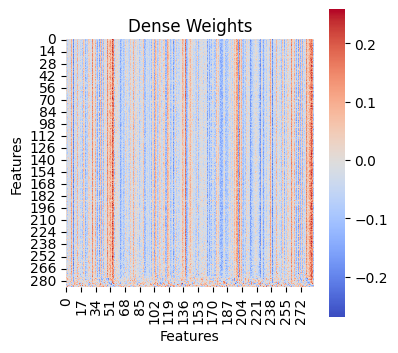

In [88]:
plt.figure(figsize=(4, 4))
sns.heatmap(wmnp0, annot=False, cmap='coolwarm', cbar=True, square=True, 
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
           )
plt.title('Dense Weights')
plt.xlabel("Features")
plt.ylabel("Features")
plt.show()

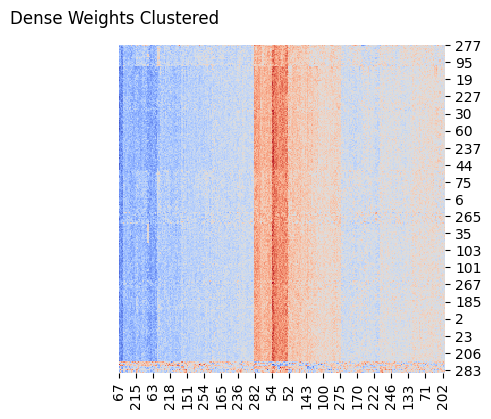

In [89]:
sns.clustermap(wmnp0, annot=False, cmap='coolwarm', cbar=False, method='ward',
               dendrogram_ratio=(0.001, 0.001),
            # xticklabels=feature_names, yticklabels=feature_names, linewidths=0.5
               figsize=(4, 4)
           )
plt.title('Dense Weights Clustered')
plt.xlabel("Features")
plt.ylabel("Features")
plt.axis('off')
plt.show()